# Automation of Pulser Streamer
> Snigdhadev and Atanu
>> to automate the NIDAQmx USB-6361

In [72]:
import inspect

## nidaqmx.system

In [23]:
import nidaqmx.system.system as system
import collections.abc as collections
from collections.abc import Sequence
import ctypes
import deprecation
import numpy

In [24]:
system.System().devices[0], system.System.local().devices[0], system.System.devices

(Device(name=Dev1), Device(name=Dev1), <property at 0x1a859593380>)

In [25]:
system.System(),system.System

(<nidaqmx.system.system.System at 0x1a859d036d0>, nidaqmx.system.system.System)

In [26]:
system.System().tasks

In [27]:
system.System.local().devices['Dev1'].terminals

['/Dev1/PFI0',
 '/Dev1/PFI1',
 '/Dev1/PFI2',
 '/Dev1/PFI3',
 '/Dev1/PFI4',
 '/Dev1/PFI5',
 '/Dev1/PFI6',
 '/Dev1/PFI7',
 '/Dev1/PFI8',
 '/Dev1/PFI9',
 '/Dev1/PFI10',
 '/Dev1/PFI11',
 '/Dev1/PFI12',
 '/Dev1/PFI13',
 '/Dev1/PFI14',
 '/Dev1/PFI15',
 '/Dev1/APFI0',
 '/Dev1/20MHzTimebase',
 '/Dev1/100MHzTimebase',
 '/Dev1/10MHzRefClock',
 '/Dev1/ai/ReferenceTrigger',
 '/Dev1/ai/SampleClock',
 '/Dev1/ai/StartTrigger',
 '/Dev1/ao/SampleClock',
 '/Dev1/ao/StartTrigger',
 '/Dev1/di/SampleClock',
 '/Dev1/di/StartTrigger',
 '/Dev1/di/ReferenceTrigger',
 '/Dev1/do/SampleClock',
 '/Dev1/do/StartTrigger',
 '/Dev1/ChangeDetectionEvent',
 '/Dev1/WatchdogExpiredEvent',
 '/Dev1/WatchdogExpirationTrigger',
 '/Dev1/AnalogComparisonEvent',
 '/Dev1/ai/ConvertClock',
 '/Dev1/ai/ConvertClockTimebase',
 '/Dev1/ai/HoldCompleteEvent',
 '/Dev1/ai/PauseTrigger',
 '/Dev1/ai/SampleClockTimebase',
 '/Dev1/ao/PauseTrigger',
 '/Dev1/ao/SampleClockTimebase',
 '/Dev1/di/SampleClockTimebase',
 '/Dev1/di/PauseTrigger',
 '/

## nidaqmx.task

In [1]:
import nidaqmx.task as task 

In [32]:
task.Task().write

<bound method Task.write of Task(name=_unnamedTask<0>)>

## nidaqmx.constants

In [60]:
import nidaqmx.constants as constants

In [79]:
print(inspect.getsource(constants.Timescale)),print(list(constants.Timescale)),print(len(constants.Timescale)),len(constants.Timescale)

class Timescale(Enum):
    USE_HOST = 16126  #: Use the host device.
    USE_IO_DEVICE = 16127  #: Use the I/O device.

[<Timescale.USE_HOST: 16126>, <Timescale.USE_IO_DEVICE: 16127>]
2


(None, None, None, 2)

## nidaqmx.stream_readers

In [52]:
import nidaqmx.stream_readers as reader 

In [59]:
reader.AnalogSingleChannelReader.mro()

[nidaqmx.stream_readers.AnalogSingleChannelReader,
 nidaqmx.stream_readers.ChannelReaderBase,
 object]

## nidaqmx.stream_writers

In [33]:
import nidaqmx.stream_writers as writer

In [81]:
writer.AUTO_START_UNSET

## nidaqmx.scale

In [82]:
import nidaqmx.scale as scale 

In [86]:
print(inspect.getsource(scale.ScaleType))

class ScaleType(Enum):
    LINEAR = 10447  #: Scale values by using the equation y=mx+b, where x is a prescaled value and y is a scaled value.
    MAP_RANGES = 10448  #: Scale values proportionally from a range of pre-scaled values to a range of scaled values.
    POLYNOMIAL = 10449  #: Scale values by using an Nth order polynomial equation.
    TABLE = 10450  #: Map a list of pre-scaled values to a list of corresponding scaled values, with all other values scaled proportionally.
    NONE = 10230  #: Do not scale electrical values to physical units.
    TWO_POINT_LINEAR = 15898  #: You provide two pairs of electrical values and their corresponding physical values. NI-DAQmx uses those values to calculate the slope and y-intercept of a linear equation and uses that equation to scale electrical values to physical values.



## nidaqmx.errors

In [87]:
import nidaqmx.errors as errors

In [90]:
print(inspect.getsource(errors.check_for_error))

@deprecation.deprecated(deprecated_in="0.8.0", details="This function will be removed in a future update.")
def check_for_error(error_code, samps_per_chan_written=None, samps_per_chan_read=None):
    from nidaqmx._library_interpreter import LibraryInterpreter
    return LibraryInterpreter().check_for_error(error_code, samps_per_chan_written, samps_per_chan_read)



## nidaqmx.utils

In [91]:
import nidaqmx.utils as utils

In [123]:
print(inspect.getsource(utils.Optional))

TypeError: module, class, method, function, traceback, frame, or code object was expected, got _SpecialForm

## nidaqmx.types

## To show plotting to Snigda Da

In [111]:
import plotly.graph_objects as go
import numpy as np

In [112]:
data = np.loadtxt('808_1100.txt')

In [113]:
x=data[:,0]; y=data[:,1]

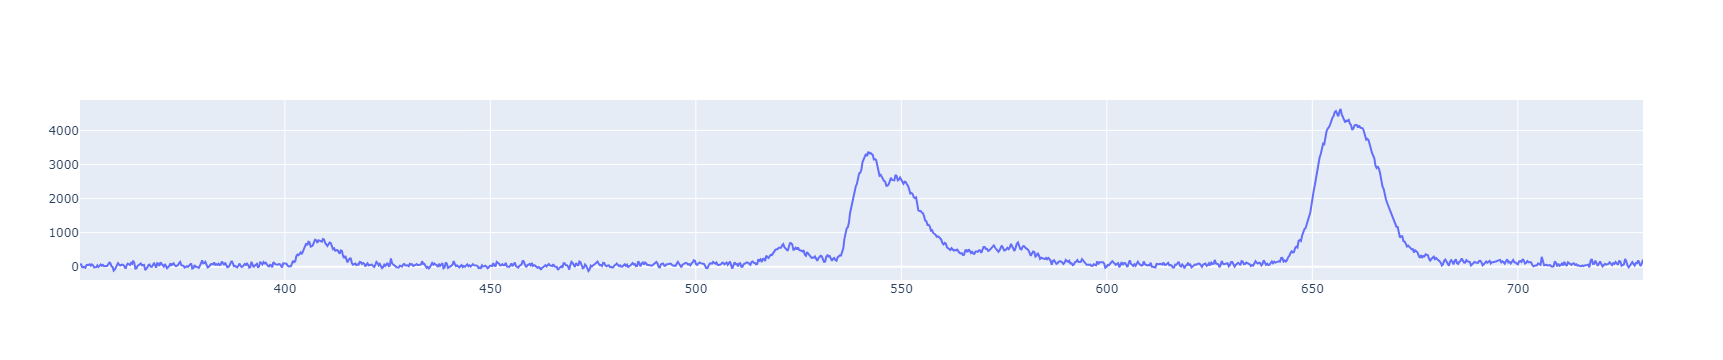

In [122]:
plot = go.Figure(data=[go.Scatter(
    x = x,
    y = y,
    mode = 'lines',)
])                 
plot.show()